In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
hist.head(2000)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-01-21,35619.60,30067.14,35501.38,125586.98,4.042427e+09,30840.30
2021-01-22,33857.39,28817.30,30840.30,109210.12,3.418228e+09,33008.02
2021-01-23,33484.73,31430.15,33008.02,39813.32,1.287619e+09,32107.29
2021-01-24,33090.99,30957.56,32107.29,33650.76,1.079876e+09,32283.66
2021-01-25,34881.18,31937.09,32283.66,59529.49,1.989618e+09,32275.27
...,...,...,...,...,...,...
2022-06-01,31956.43,29324.10,31782.16,43767.18,1.343137e+09,29789.58
2022-06-02,30647.18,29574.16,29789.58,31049.70,9.323400e+08,30439.63
2022-06-03,30676.70,29249.37,30439.63,24607.85,7.340001e+08,29680.30


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

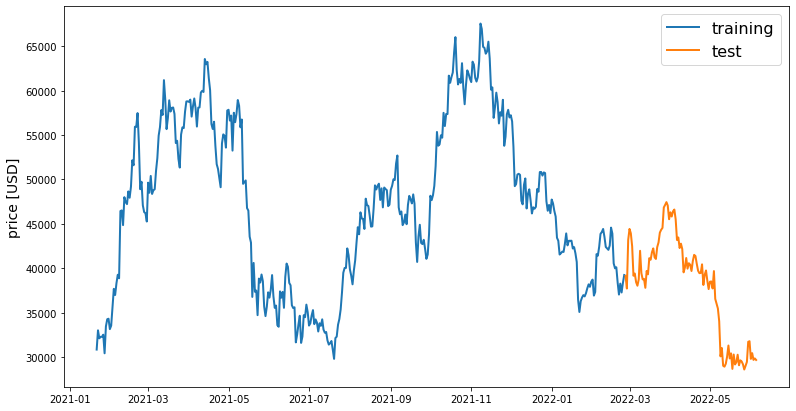

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 5s 107ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 2/20
13/13 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 3/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 4/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 5/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 6/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 7/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 8/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 10/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/2

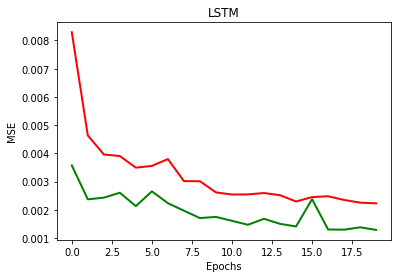

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.027091024316467267

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.0012899011783694707

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7088060494900739

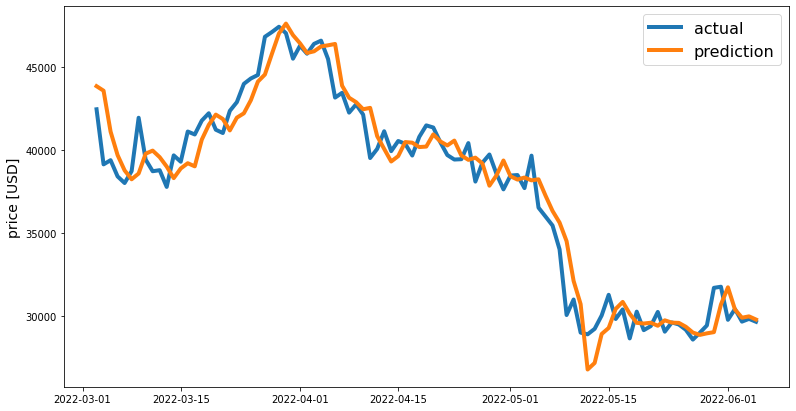

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=4)

In [ ]:
x_input=endpoint[230:].reshape(1,-1)
x_input.shape

AttributeError: ignored

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

NameError: ignored

In [ ]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

NameError: ignored